In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geopandas as gpd
import seaborn as sns

# **R A P O R T**
## Eksploracyjna analiza danych i inżynieria cech na przykładzie rejestru aptek
####  Konrad Dąbrowski

### Zakres danych użytych w analizie
W związku z ukierunkowaniem analizy na znalezienie czynników wpływających na długość działania aptek, do dalszych etapów pracy wybrane zostały wyłącznie te kolumny, które mogą mieć znaczenie dla tego aspektu. Ze względu na ograniczony czas przeznaczony na analizę, część zmiennych została odrzucona już na etapie wstępnego przeglądu danych. Do dalszej analizy pozostawiono następujące kolumny:
- *stan_apteki* – wskazuje bieżący stan apteki, tj. czy apteka jest aktywna, czy zawieszona lub zamknięta,
- *rodzaj_apteki* – określa typ apteki,
- *data_uruchomienia_apteki* – data, kiedy apteka rozpoczęła swoją działalność,
- *data_wydania_zezwolenia* – data, kiedy apteka otrzymała zezwolenie na prowadzenie działalności farmaceutycznej,
- *data_cofniecia_zezwolenia* – data, kiedy zezwolenie na prowadzenie apteki zostało cofnięte,
- *data_wygaszenia_zezwolenia* – data, kiedy zezwolenie na prowadzenie apteki wygasło,
- *wojewodztwo* – określa województwo, w którym znajduje się apteka,
- *powiat* – określa powiat, w którym apteka funkcjonuje,
- *czy_szprzedaz_wysylkowa* – informacja o tym, czy apteka prowadzi sprzedaż wysyłkową,
- *telefon* – numer telefonu apteki,
- *email* – adres email apteki,
- *kierownik_npwz* – numer prawa wykonywania zawodu farmaceuty (NPWZ), który pełni funkcję kierownika apteki,
- *kierownik_iiw* – numer wpisu do rejestru osób uprawnionych do wykonywania zawodu technika farmaceutycznego (tzw. IIW – identyfikator innej formy uprawnień),
- *wlasciciel_forma_prawna* – określa formę prawną właściciela apteki.

 Do analizy uwzględniono wyłącznie apteki ogólnodostępne oraz punkty apteczne,
ponieważ stanowią one najbardziej reprezentatywną grupę placówek działających
na rynku detalicznym i są poddane podobnym regulacjom. Pozostałe typy aptek,
takie jak apteki szpitalne czy zakładowe, charakteryzują się innym profilem działalności, dlatego zostały pominięte.


#### *Wczytanie danych*

In [6]:
rejestr = pd.read_excel("rejestr_aptek.xls")
ludnosc_powiat = pd.read_csv("ludnosc_powiat.csv", sep=';')

#### *Filtrowanie i wstępne czyszczenie rejestru aptek*

In [8]:
rejestr = rejestr[['stan_apteki', 'rodzaj_apteki', 'data_uruchomienia_apteki', 
 'data_wydania_zezwolenia', 'data_cofniecia_zezwolenia', 'data_wygaszenia_zezwolenia', 'wojewodztwo', 'powiat', 
 'czy_szprzedaz_wysylkowa', 'telefon', 'email', 'kierownik_npwz', 'kierownik_iiw', 'wlasciciel_forma_prawna']]
rejestr = rejestr[rejestr['rodzaj_apteki'].isin(['APTEKA OGÓLNODOSTĘPNA', 'PUNKT APTECZNY'])]
rejestr['wojewodztwo'] = rejestr['wojewodztwo'].str.lower().str.strip().str.replace(" ", "-")

### Analiza i uzupełnianie braków danych

Analiza braków danych wykazała, że w dziewięciu cechach występują niepełne informacje, które wymagają szczegółowego przeanalizowania i uzupełnienia. Szczegółowy rozkład braków danych przedstawiono w poniższej tabeli.

In [10]:
rejestr.isna().sum().to_frame(name='Ilość brakujących danych').rename_axis('Cecha')

,Ilość brakujących danych
Cecha,
stan_apteki,0
rodzaj_apteki,0
data_uruchomienia_apteki,162
data_wydania_zezwolenia,1
data_cofniecia_zezwolenia,20337
data_wygaszenia_zezwolenia,13788
wojewodztwo,0
powiat,0
czy_szprzedaz_wysylkowa,0


#### *Ekstrakcja roku otwarcia i końca zezwolenia na prowadzenie aptek*
W celu uporania się z brakami w kolumnie *data_uruchomienia_apteki*, brakujące wartości zostały zastąpione danymi z cechy *data_wydania_zezwolenia*. Analogiczne działanie zastosowano w przypadku kolumny data_cofnięcia_zezwolenia, gdzie braki uzupełniono wartościami z cechy *data_wygaszenia_zezwolenia*. Połączone dane z tych dwóch kolumn będą teraz traktowane jako *data_końca_zezwolenia*. 

Choć takie podejście może wiązać się z pewnym opóźnieniem względem rzeczywistej daty zdarzenia, umożliwia zachowanie ciągłości danych oraz ich pełniejszą analizę. Możliwe jest, dzięki temu, uwzględnienie większej liczby rekordów w dalszych etapach pracy.

In [12]:
rejestr['data_uruchomienia_apteki'] = rejestr['data_uruchomienia_apteki'].combine_first(rejestr['data_wydania_zezwolenia'])
rejestr['data_konca_zezwolenia'] = rejestr['data_cofniecia_zezwolenia'].combine_first(rejestr['data_wygaszenia_zezwolenia'])

#### *Binaryzacja i kodowanie zmiennych*

W przypadku kolumn *email* oraz *telefon* istotna była nie treść, lecz sam fakt występowania tych wartości. W związku z tym te cechy zostały zbinaryzowane: 0 – brak wartości, 1 – wartość obecna, a nazwy zostały zmienione na *czy_email* oraz *czy_telefon*.

Kolumny *kierownik_iiw* oraz *kierownik_npwz* są względem siebie wykluczające, jeśli jedna z nich zawiera wartość, druga pozostaje pusta i odwrotnie. Z tego powodu obie kolumny zakodowano w zmiennej *kierownik*, przy czym, 1 oznacza obecność danych z kolumny *kierownik_iiw*, a 2 obecność z kolumny *kierownik_npwz*. Nowa kolumna została wstępnie zainicjalizowana wartością *np.nan*, aby uniknąć nadpisania potencjalnych braków danych i umożliwić ich późniejszą identyfikację.


In [14]:
rejestr['czy_email'] = rejestr['email'].notna().astype(int)
rejestr['czy_telefon'] = rejestr['telefon'].notna().astype(int)

rejestr['kierownik'] = np.nan
rejestr.loc[rejestr['kierownik_iiw'].notna(), 'kierownik'] = 1
rejestr.loc[rejestr['kierownik_npwz'].notna(), 'kierownik'] = 2

rejestr = rejestr[['stan_apteki', 'rodzaj_apteki', 'wojewodztwo', 'powiat', 'data_uruchomienia_apteki', 'data_konca_zezwolenia', 'czy_szprzedaz_wysylkowa', 
                   'czy_telefon', 'czy_email', 'kierownik', 'wlasciciel_forma_prawna']]

Na obecnym etapie analizy nie zastosowano metod usuwania braków danych ani ich szacowania na podstawie pozostałych cech. W niektórych przypadkach takie podejście okazało się skuteczne, jednak nie we wszystkich. W trzech zmiennych nadal występują braki (tabela poniżej). Z powodu, że dane obejmują cały kraj, analizowanie ich na tym poziomie może prowadzić do zbyt ogólnych wniosków. Odsetek brakujących danych może się istotnie różnić w zależności od powiatu, dlatego na dalszym etapie niezbędna jest bardziej szczegółowa analiza na poziomie powiatowym. Takie podejście pozwala uniknąć potencjalnego zniekształcenia wyników analizy, do którego mogłoby dojść w przypadku usunięcia zbyt dużej liczby obserwacji z danego regionu.

In [16]:
rejestr.isna().sum().to_frame(name='Ilość brakujących danych').rename_axis('Cecha')

,Ilość brakujących danych
Cecha,
stan_apteki,0
rodzaj_apteki,0
wojewodztwo,0
powiat,0
data_uruchomienia_apteki,0
data_konca_zezwolenia,12659
czy_szprzedaz_wysylkowa,0
czy_telefon,0
czy_email,0


### Klasteryzacja powiatów

Przy analizowaniu cechy powiaty napotkano na problem związany z liczbą jednostek administracyjnych.

In [19]:
print('Znaleziono {} powiatów.'.format(len(rejestr['powiat'].unique())))

Znaleziono 375 powiatów.


Stwierdzono występowanie 10 par powiatów o identycznych nazwach, lecz zlokalizowanych w różnych województwach:
1. powiat bielski – województwo podlaskie oraz śląskie,
2.	powiat brzeski – województwo małopolskie oraz opolskie,
3.	powiat grodziski – województwo mazowiecki oraz wielkopolskie,
4.	powiat krośnieński – województwo lubuskie oraz podkarpackie,
5.	powiat nowodworski – województwo mazowieckie oraz pomorskie,
6.	powiat opolski – województwo lubelskie oraz opolskie,
7.	powiat ostrowski – województwo mazowieckie oraz wielkopolskie,
8.	powiat średzki – województwo dolnośląskie oraz wielkopolskie,
9.	powiat świdnicki – województwo dolnośląskie oraz lubelskie,
10.	powiat tomaszowski – województwo lubelskie oraz łódzkie.

W celu rozwiązania problemu, do nazw powiatów dodano odpowiednie kody województw, zgodne z dwiema pierwszymi cyframi systemu identyfikatorów TERC (system identyfikacji jednostek podziału terytorialnego kraju). Pozwoliło to na rozróżnienie wszystkich 380 powiatów – 66 miast na prawach powiatu oraz 314 powiatów ziemskich.

In [21]:
kod_woj = {
    "dolnośląskie": "02",
    "kujawsko-pomorskie": "04",
    "lubelskie": "06",
    "lubuskie": "08",
    "łódzkie": "10",
    "małopolskie": "12",
    "mazowieckie": "14",
    "opolskie": "16",
    "podkarpackie": "18",
    "podlaskie": "20",
    "pomorskie": "22",
    "śląskie": "24",
    "świętokrzyskie": "26",
    "warmińsko-mazurskie": "28",
    "wielkopolskie": "30",
    "zachodniopomorskie": "32"
}
rejestr['kod_woj'] = rejestr['wojewodztwo'].map(kod_woj)
rejestr['powiat'] = rejestr['powiat'].str.strip() + ' ' + rejestr['kod_woj'].str.strip()
rejestr['powiat'] = rejestr['powiat'].str.replace(r'\s*\(.*\)', '', regex=True)

In [22]:
print('Liczba powiatów po uwzględnieniu kodu województwa: {}'.format(len(rejestr['powiat'].unique())))

Liczba powiatów po uwzględnieniu kodu województwa: 380


#### *Problem zbyt dużej kardynalności nazw powiatów*
Kardynalność rzędu 380 została uznana za zbyt wysoką. W celu redukcji cech pozyskano dane dotyczące liczby ludności oraz gęstości zaludnienia (na 1 km²) w powiatach w latach 2002–2023. Dane te zostały pobrane z Banku Danych Lokalnych GUS, który umożliwia ręczne wybieranie statystyk, regionów oraz przedziału czasowego.

Wybrano maksymalnie dostępny przedział czasowy, ponieważ nowsze dane nie były dostępne, a obecny podział administracyjny powiatów obowiązuje od 2002 roku. Wyjątek stanowi miasto Wałbrzych, które w latach 2003–2013 utraciło status miasta na prawach powiatu. W bazie możliwe było jednak pobranie informacji dotyczących samego miasta, zatem wartości dla powiatu wałbrzyskiego w tamtych latach zredukowano o dane dla miasta. Pozwoliło to na uzyskanie ciągłego zestawu danych dla wszystkich powiatów w Polsce.

In [24]:
ludnosc_powiat['Nazwa'] = (
    ludnosc_powiat['Nazwa']
    .str.replace('Powiat', '', regex=False)
    .str.replace('m.', '', regex=False)
    .str.replace('st.', '', regex=False)
    .str.strip()
)

kody = ludnosc_powiat[['Nazwa', 'Kod']]

ludnosc_powiat['Kod'] = ludnosc_powiat['Kod'].astype(str).str.zfill(7).str[-7:-5]
ludnosc_powiat.set_index(
    ludnosc_powiat['Nazwa'].str.strip() + ' ' + ludnosc_powiat['Kod'].str.strip(), 
    inplace=True
)

ludnosc_powiat.drop(['Kod', 'Nazwa'], axis=1, inplace=True)
ludnosc_powiat = ludnosc_powiat.map(lambda x: float(str(x).replace(',', '.')))

In [25]:
kody['Kod'] = kody['Kod'].astype(str).str.zfill(7).str[-7:-3]
kody.set_index(kody['Nazwa'].str.strip() + ' ' + kody['Kod'].str.strip().str[-4:-2], inplace=True)
kody.drop('Nazwa', axis=1, inplace=True)

In [26]:
gestosc = np.ceil(ludnosc_powiat.loc[:, 'gęstość-2002':'gęstość-2023'])

ludnosc = ludnosc_powiat.loc[:, 'ludność-2002':'ludność-2023']*1000
ludnosc.columns = [f"{year}" for year in range(2002, 2024)]
ludnosc = ludnosc.sort_index()

In [27]:
zredukowane = rejestr.copy()
zredukowane['rok_uruchomienia_apteki'] = pd.to_datetime(rejestr['data_uruchomienia_apteki']).dt.year
zredukowane['rok_konca_zezwolenia'] = pd.to_datetime(rejestr['data_konca_zezwolenia']).dt.year.astype('Int64')

powiaty = rejestr['powiat'].unique()
lata = pd.Index(range(1900, 2025))
apteki = pd.DataFrame()

for p in powiaty:
    uruchomienia = (
        zredukowane[zredukowane['powiat'] == p]
        .groupby('rok_uruchomienia_apteki')
        .size()
        .reindex(lata, fill_value=0)
        .to_frame()
    )
    
    zakonczenia = (
        zredukowane[zredukowane['powiat'] == p]
        .groupby('rok_konca_zezwolenia')
        .size()
        .reindex(lata, fill_value=0)
        .to_frame()
    )
    
    aktywne = (uruchomienia - zakonczenia).cumsum().loc[2002:2023]
    aktywne.columns = [p]
    aktywne.index = [f"{year}" for year in range(2002, 2024)]
    apteki = pd.concat([aktywne, apteki], axis=1)
    
apteki = apteki.T.sort_index()
obciazenie = ludnosc / apteki

#### *Porównanie mediany i średniej jako miary tendencji centralnej zbioru*
Pozyskane dane zostały wykorzystane do klasteryzacji powiatów pod względem gęstości oraz obciążenia aptek, rozumianego jako stosunek liczby ludności do liczby aptek w poszczególnych latach. W celu wyboru odpowiedniej miary tendencji centralnej przeanalizowano rozkłady wartości średniej i mediany, co przedstawiono na poniższym wykresie. 

Rozkład mediany gęstości wykazywał skośność równą 2,39, natomiast skośność rozkładu mediany obciążenia wynosiła 0,68. Oba rozkłady cechowały się asymetrią prawostronną, co oznacza, że większość obserwacji skupiała się wokół niższych wartości. W związku z tym, do dalszych obliczeń wybrano medianę jako bardziej odporną na wartości odstające, które mogłyby zaburzyć średnią.

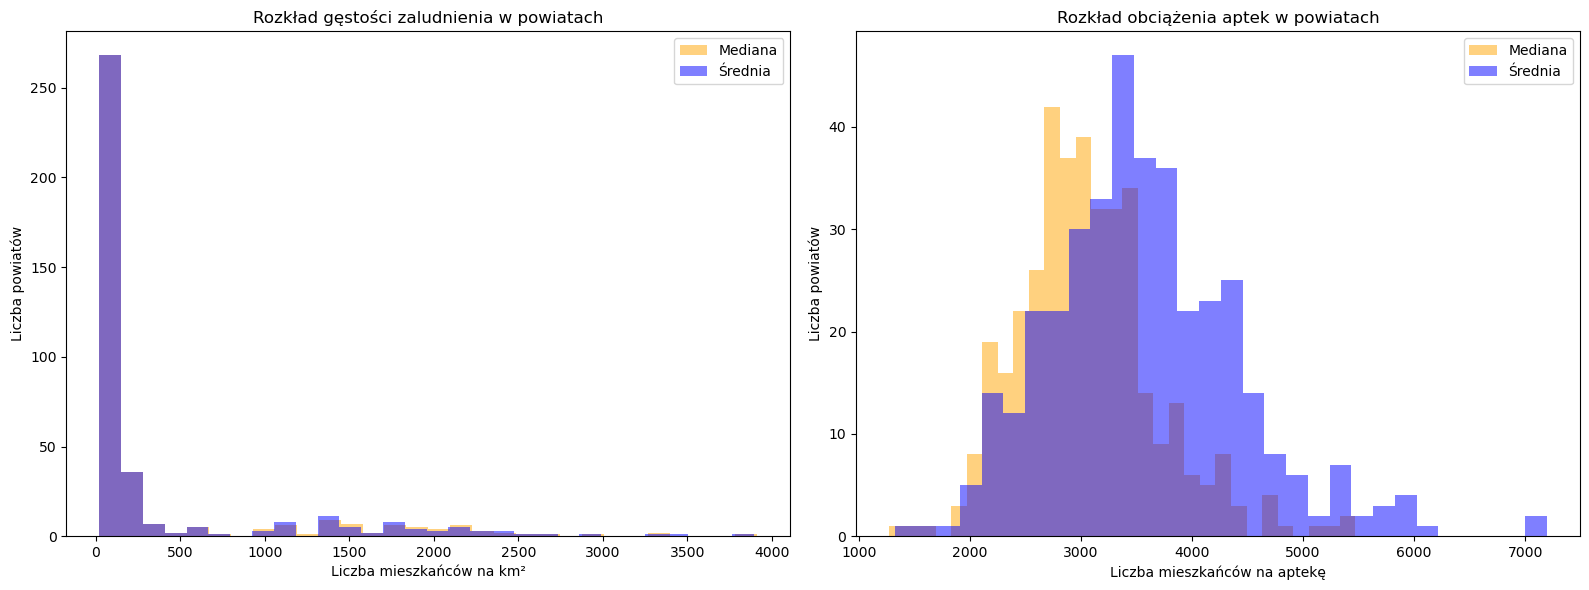

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(gestosc.median(axis=1), bins=30, alpha=0.5, label='Mediana', color='orange')
axes[0].hist(gestosc.mean(axis=1), bins=30, alpha=0.5, label='Średnia', color='blue')
axes[0].legend()
axes[0].set_title('Rozkład gęstości zaludnienia w powiatach')
axes[0].set_xlabel('Liczba mieszkańców na km²')
axes[0].set_ylabel('Liczba powiatów')

axes[1].hist(obciazenie.median(axis=1), bins=30, alpha=0.5, label='Mediana', color='orange')
axes[1].hist(obciazenie.mean(axis=1), bins=30, alpha=0.5, label='Średnia', color='blue')
axes[1].legend()
axes[1].set_title('Rozkład obciążenia aptek w powiatach')
axes[1].set_xlabel('Liczba mieszkańców na aptekę')
axes[1].set_ylabel('Liczba powiatów')

plt.tight_layout()
plt.show()

In [30]:
skosnosc = skew(gestosc.median(axis=1))
print("Skośność rozkładu mediany gęstości: {}".format(skosnosc.round(2)))

skosnosc = skew(obciazenie.median(axis=1))
print("Skośność rozkładu mediany obciążenia: {}".format(skosnosc.round(2)))

Skośność rozkładu mediany gęstości: 2.39
Skośność rozkładu mediany obciążenia: 0.69


In [31]:
obciazenie = np.ceil(obciazenie.median(axis=1).to_frame(name='obciazenie aptek'))
gestosc = np.ceil(gestosc.median(axis=1).to_frame(name='gestosc zaludnienia'))
cechy_powiatow = pd.concat([obciazenie, gestosc], axis=1)

#### *Metoda łokcia do wyboru optymalnej liczby klastrów*

W celu określenia optymalnej liczby klastrów, połączono dane dotyczące mediany gęstości zaludnienia oraz obciążenia aptek dla każdego powiatu w jedną tabelę. Następnie dane zostały ustandaryzowane, aby zapewnić porównywalność zmiennych o różnych skalach. Do analizy zastosowano metodę łokcia, która pozwala na wybór najbardziej odpowiedniej liczby klastrów w algorytmie grupowania K-średnich. Metoda ta polega na znalezieniu k środków w taki sposób, aby łączna suma odległości punktów od najbliższego centroidu była jak najmniejsza. W analizie rozważano wartości k od 2 do 20.

Na poniższym wykresie oś X przedstawia liczbę klastrów, a oś Y łączną sumę odległości punktów od przypisanych im centroidów. Punkt, w którym dalsze zwiększanie liczby klastrów nie prowadzi już do istotnego zmniejszenia tej sumy, uznawany jest za optymalną liczbę klastrów. Na poniższym wykresie charakterystyczne załamanie, przypominające kształtem zgięcie łokcia, widoczne jest przy 3 klastrach.

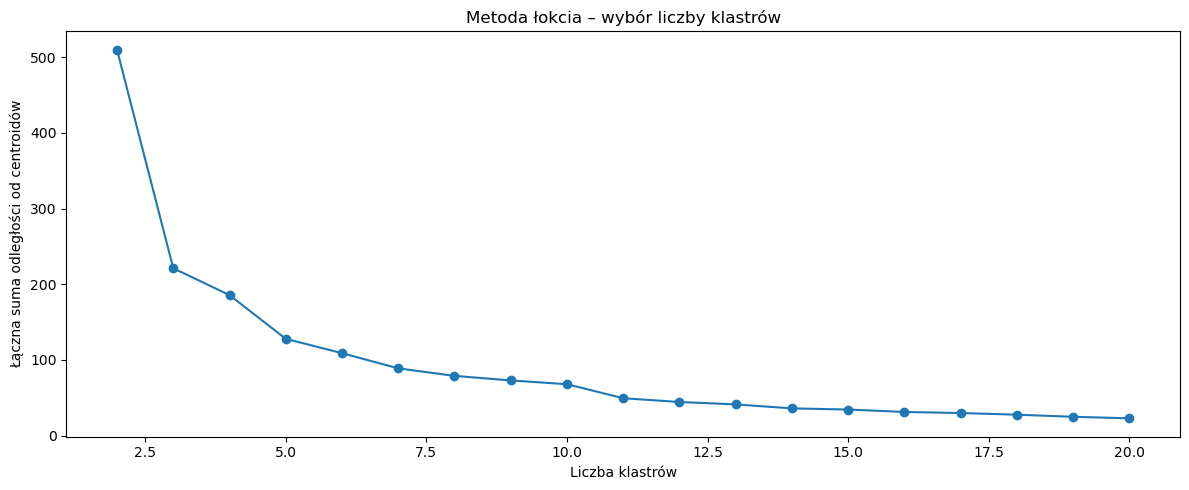

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cechy_powiatow)

suma_odleglosci = []
k_range = range(2, 21)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit_predict(X_scaled)
    suma_odleglosci.append(model.inertia_)

plt.figure(figsize=(12,5))
plt.plot(k_range, suma_odleglosci, marker='o')
plt.title('Metoda łokcia – wybór liczby klastrów')
plt.xlabel('Liczba klastrów')
plt.ylabel('Łączna suma odległości od centroidów')
plt.tight_layout()
plt.show()

#### *Klasteryzacja powiatów metodą k-średnich*

In [35]:
kmeans = KMeans(n_clusters=3, random_state=0)
cechy_powiatow['klaster'] = kmeans.fit_predict(X_scaled)

#### *Charakterystyka klastrów powiatów*
W celu przeprowadzenia charakterystyki klastrów sporządzono wykresy pudełkowe, widoczne poniżej, przedstawiające rozkład gęstości zaludnienia oraz obciążenia aptek w poszczególnych klastrach. Dodatkowo, w celu analizy przestrzennej, klastry zostały naniesione na mapę Polski. Na tej podstawie można wyróżnić trzy typy powiatów:
- Klaster 0 – obejmuje głównie powiaty o niskiej gęstości zaludnienia i niskim obciążeniu aptek. Są to w głównie obszary wiejskie i małe miasta.
- Klaster 1 – skupia powiaty o niskiej gęstości zaludnienia, ale wysokim obciążeniu aptek. Często występują w sąsiedztwie dużych miast (klaster 2), co może wskazywać na zależność od infrastruktury medycznej większych ośrodków miejskich.
- Klaster 2 – reprezentuje powiaty o wysokiej gęstości zaludnienia i najbardziej zróżnicowanym, choć małym obciążeniu aptek. Klaster ten koncentruje się wokół największych miast i aglomeracji.

Powyższa charakterystyka potwierdza, że dokonany podział powiatów na klastry jest trafny i dobrze odwzorowuje zróżnicowanie terytorialne w kontekście dostępności usług aptecznych. W związku z tym, kolumnę zawierającą nazwę powiatu w rejestrze aptek zastąpiono nową cechą *klaster_powiat*, która zawiera numer przypisanego klastra dla danego powiatu.

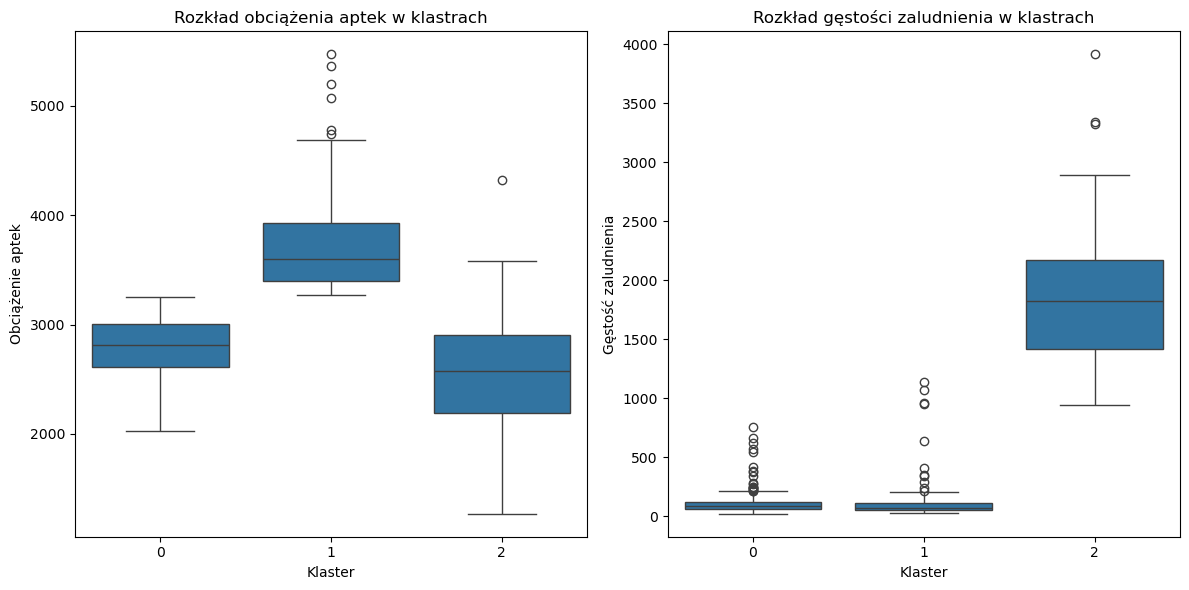

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='klaster', y='obciazenie aptek', data=cechy_powiatow.reset_index())
plt.title('Rozkład obciążenia aptek w klastrach')
plt.ylabel('Obciążenie aptek')
plt.xlabel('Klaster')

plt.subplot(1, 2, 2)
sns.boxplot(x='klaster', y='gestosc zaludnienia', data=cechy_powiatow.reset_index())
plt.title('Rozkład gęstości zaludnienia w klastrach')
plt.ylabel('Gęstość zaludnienia')
plt.xlabel('Klaster')

plt.tight_layout()
plt.show()

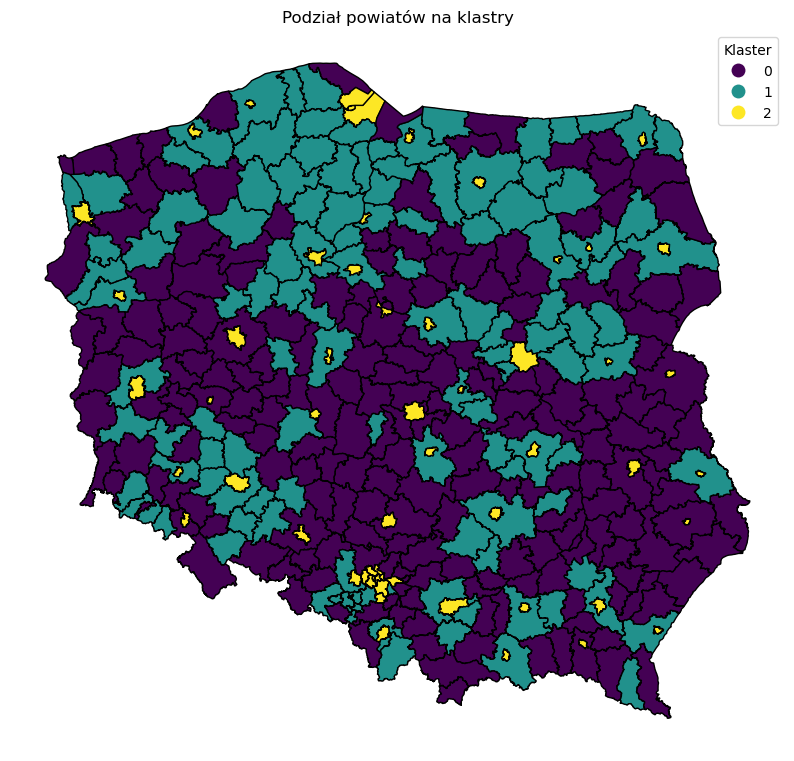

In [38]:
gdf = gpd.read_file('powiaty/powiaty.shp')
reduced = pd.concat([cechy_powiatow[['klaster']], kody], axis=1)
gdf = gdf.merge(reduced, left_on='JPT_KOD_JE', right_on='Kod')
gdf['klaster'] = gdf['klaster'].astype('category')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='klaster', cmap='viridis', legend=True, edgecolor='black', ax=ax)

leg = ax.get_legend()
leg.set_title("Klaster")

plt.title('Podział powiatów na klastry')
plt.axis('off')
plt.show()

#### *Mapowanie klastrów do powiatów*

In [40]:
rejestr['powiat'] = rejestr['powiat'].map(cechy_powiatow['klaster'].to_dict())
rejestr = rejestr.rename(columns={'powiat': 'klaster_powiat'})

### Ponowna analiza braków danych w kontekście klastrów powiatów
W poniższej tabeli dla cechy *data_konca_zezwolenia* zbadano brakujące wartości w podziale na status apteki.

In [42]:
rejestr.groupby('stan_apteki')['data_konca_zezwolenia'].apply(lambda x: x.isna().sum()).to_frame('Ilość brakujących dat końca zezwolenia')

,Ilość brakujących dat końca zezwolenia
stan_apteki,
AKTYWNA,12340
CZASOWO NIECZYNNA,86
NIEAKTYWNA,38
NIEAKTYWNA - ZAWIESZENIE DZIAŁALNOŚCI,189
OCZEKUJĄCA,5
UNIERUCHOMIONA DECYZJĄ WIF,1


#### *Stosunek nieaktywnych do wszytkich aptek*
Braki dat końca zezwolenia w przypadku aptek aktywnych jest uzasadniony, dlatego dalszą analizę ograniczono wyłącznie do rekordów, które nie są aktywne. Wśród wszystkich aptek o statusie nieaktywnym, 3,49% nie posiada informacji o dacie końca zezwolenia.

In [44]:
licznik = len(rejestr[
              (rejestr['stan_apteki'] != 'AKTYWNA') & 
              (rejestr['data_konca_zezwolenia'].isna())])

mianownik = len(rejestr[(rejestr['stan_apteki'] != 'AKTYWNA')])
stosunek = licznik / mianownik

print("Procent nieaktywnych aptek z brakującymi danymi do wszystkich nieaktywnych wynosi {} %.".format(np.round(licznik / mianownik * 100, 2)))

Procent nieaktywnych aptek z brakującymi danymi do wszystkich nieaktywnych wynosi 3.49 %.


#### *Stosunek nieaktywnych wg klastrów*

Wartość ta nie wydaje się znacząca, jednak zdecydowano się sprawdzić jej rozkład w poszczególnych klastrach, w niektórych z nich udział brakujących danych mógłby być na tyle wysoki, że zaburzyłby późniejsze analizy. Jednak, jak pokazano w poniższej tabeli, w żadnym z klastrów udział brakujących danych nie przekracza 5%, co pozwala na bezpieczne usunięcie tych rekordów bez ryzyka istotnego zaburzenia wyników.

In [46]:
licznik_w = rejestr[
    (rejestr['stan_apteki'] != 'AKTYWNA') &
    (rejestr['data_konca_zezwolenia'].isna())
].groupby('klaster_powiat').size()
mianownik_w = rejestr[rejestr['stan_apteki'] != 'AKTYWNA'].groupby('klaster_powiat').size()
stosunek_w = ((licznik_w / mianownik_w) * 100).to_frame(name='Odsetek brakujących dat końca zezwolenia').dropna().round(2)

stosunek_w.sort_values(by='Odsetek brakujących dat końca zezwolenia', ascending=False)

,Odsetek brakujących dat końca zezwolenia
klaster_powiat,
2,3.80
0,3.67
1,2.58


In [47]:
rejestr = rejestr[~((rejestr['stan_apteki'] != 'AKTYWNA') & (rejestr['data_konca_zezwolenia'].isna()))]

#### *Nadal występujce braki*
Cecha *data_konca_zezwolenia* nadal zawiera brakujące wartości dla aktywnych aptek. W związku z tym zdecydowano o jej zastąpieniu nową zmienną, opisującą czas działania apteki. Przed przekształceniem przeanalizowano jednak liczność etykiet dla obu cech czasowych.

In [49]:
rejestr.groupby('stan_apteki')['data_konca_zezwolenia'].apply(lambda x: x.isna().sum()).to_frame('Ilość brakujących dat końca zezwolenia')

,Ilość brakujących dat końca zezwolenia
stan_apteki,
AKTYWNA,12340
NIEAKTYWNA,0


In [50]:
unikalne = rejestr[['data_uruchomienia_apteki', 'data_konca_zezwolenia']].nunique().to_frame(name='Liczba etykiet').rename_axis('Cecha')
unikalne

,Liczba etykiet
Cecha,
data_uruchomienia_apteki,7342
data_konca_zezwolenia,3189


#### *Duża kardynalność "zmiennych czasowych"*

Kardynalność okazała się zbyt wysoka, dlatego zdecydowano się na redukcję obu cech do poziomu roku. W wyniku tego działania liczba etykiet została zmniejszona o ponad 99%. Po redukcji liczba unikalnych wartości dla roku uruchomienia wynosi 42, a dla roku zakończenia działalności 24. Pozwoliło to na wyznaczenie czasu działania aptek. W przypadku aptek aktywnych okres ten liczony jest do roku 2025, co odzwierciedla ich aktualny staż funkcjonowania.

In [52]:
rejestr['rok_uruchomienia_apteki'] = pd.to_datetime(rejestr['data_uruchomienia_apteki']).dt.year
rejestr['rok_konca_zezwolenia'] = pd.to_datetime(rejestr['data_konca_zezwolenia']).dt.year
rejestr = rejestr[['stan_apteki', 'rodzaj_apteki', 'wojewodztwo', 'klaster_powiat', 'rok_uruchomienia_apteki', 'rok_konca_zezwolenia', 'czy_szprzedaz_wysylkowa', 
                   'czy_telefon', 'czy_email', 'kierownik', 'wlasciciel_forma_prawna', ]]

In [53]:
u = unikalne.loc['data_uruchomienia_apteki', 'Liczba etykiet']
k = unikalne.loc['data_konca_zezwolenia', 'Liczba etykiet']

for x in ['rok_uruchomienia_apteki', 'rok_konca_zezwolenia']:
    print('Liczba etykiet zmiennej {}: {}'.format(x, len(rejestr[x].unique())))

print('\nKardnalność zbioru zmiennej opisującej rok uruchomienia apteki zredukowano o {}%.'
      .format(round((u - len(rejestr['rok_uruchomienia_apteki'].unique())) / u * 100, 2)))

print('Kardnalność zbioru zmiennej opisującej rok końca zezwolenia na prowadzenie apteki zredukowano o {}%.'
      .format(round((k - len(rejestr['rok_konca_zezwolenia'].unique())) / k * 100, 2)))

Liczba etykiet zmiennej rok_uruchomienia_apteki: 42
Liczba etykiet zmiennej rok_konca_zezwolenia: 24

Kardnalność zbioru zmiennej opisującej rok uruchomienia apteki zredukowano o 99.43%.
Kardnalność zbioru zmiennej opisującej rok końca zezwolenia na prowadzenie apteki zredukowano o 99.25%.


#### *Zastąpienie zmiennej*

In [55]:
rejestr['lata_dzialania'] = rejestr['rok_konca_zezwolenia'].fillna(2025) - rejestr['rok_uruchomienia_apteki']
rejestr['lata_dzialania'] = rejestr['lata_dzialania'].astype(int)

#### *Cecha kierownik - braki*
W przypadku cechy *kierownik* brak danych wynosi 42,47% dla całego zbioru. To na tyle duża wartość, że rzetelne oszacowanie brakujących danych byłoby trudne i potencjalnie obarczone dużym błędem. W celu sprawdzenia czy braki danych mogą być w jakimś stopniu zależne od innych zmiennych, przeanalizowano ich rozkład względem aktywności aptek. 

Okazało się, że 95,77% nieaktywnych aptek nie zawiera informacji o kierowniku. Jest to uzasadnione, istnieje duże prawdopodobieństwo, że dane wrażliwe, takie jak numer prawa wykonywania zawodu, są usuwane po zamknięciu apteki. W przypadku aktywnych aptek braki te stanowią jedynie 4,44%. W związku z powyższym należy zauważyć, że wszystkie kolejne analizy, w których wykorzystywana jest cecha kierownik, są w pewnym stopniu obarczone błędem wynikającym z niepełnych danych. 

Mimo to, w dalszych krokach przeanalizowano zależność pomiędzy rodzajem apteki a rodzajem kierownika. Z obserwacji wynika, że wśród aptek ogólnodostępnych aż 99,99% kierowników to zawodowi farmaceuci, natomiast w punktach aptecznych 90,10% kierowników stanowią technicy farmaceutyczni.

In [57]:
print("Brak danych dla cechy 'kierownik' wynosi {}% dla całego zbioru."
      .format((rejestr['kierownik'].isna().sum() / rejestr['kierownik'].shape[0] * 100).round(2))
)

Brak danych dla cechy 'kierownik' wynosi 42.47% dla całego zbioru.


In [58]:
(pd.crosstab(rejestr['stan_apteki'], rejestr['kierownik'], dropna=False, normalize='index')*100).round(2)

kierownik,1.0,2.0,NaN
stan_apteki,,,
AKTYWNA,4.11,91.45,4.44
NIEAKTYWNA,0.15,4.09,95.77


In [59]:
(pd.crosstab(rejestr['rodzaj_apteki'], rejestr['kierownik'], normalize='index')*100).round(2)

kierownik,1.0,2.0
rodzaj_apteki,,
APTEKA OGÓLNODOSTĘPNA,0.01,99.99
PUNKT APTECZNY,90.10,9.90


#### *Sprawdzenie zależności kierownik - rodzaj_apteki*
Aby statystycznie potwierdzić istnienie zależności między tymi dwiema zmiennymi, zastosowano test chi-kwadrat niezależności. Test ten sprawdza, czy zmienne kategoryczne są od siebie statystycznie niezależne. Wartość obliczonej statystyki chi-kwadrat to 10868,78, a wartość p-value to 0,0. Otrzymany wynik p-value równy 0.0 (czyli mniejszy niż jakikolwiek przyjęty poziom istotności, np. 0,05) pozwala jednoznacznie odrzucić hipotezę zerową o niezależności zmiennych. Oznacza to, że istnieje statystycznie istotna zależność między rodzajem apteki a typem osoby pełniącej funkcję kierownika. W związku z tym cecha kierownik została wykluczona z dalszej analizy.

In [61]:
import pandas as pd
from scipy.stats import chi2_contingency

tab = pd.crosstab(rejestr['rodzaj_apteki'], rejestr['kierownik'])

chi2, p, d, e = chi2_contingency(tab)
print(f"Wartość chi2: {chi2}, p-value: {p}")

Wartość chi2: 10868.776833488791, p-value: 0.0


In [62]:
rejestr.drop('kierownik', axis=1, inplace=True)

#### *Cecha wlasciciel_forma_prawna - braki*

Kolumna *właściciel_forma_prawna* zawiera 792 brakujące wartości, co stanowi 3,74% wszystkich rekordów w zbiorze. Analiza braków w podziale na klastry powiatów (tabela poniżej) wykazała, że odsetek brakujących danych nie przekracza 5% w żadnym z klastrów. W związku z tym uznano, że brakujące rekordy można bezpiecznie usunąć bez istotnego wpływu na jakość dalszych analiz.

In [64]:
licznik = len(rejestr[(rejestr['wlasciciel_forma_prawna'].isna())])
mianownik = len(rejestr)

print("Procent brakujących danych w formie prawnej własciciela wynosi {} %.".format(np.round(licznik / mianownik * 100, 2)))

Procent brakujących danych w formie prawnej własciciela wynosi 3.74 %.


In [65]:
licznik = rejestr[
    (rejestr['wlasciciel_forma_prawna'].isna())
].groupby('klaster_powiat').size()
mianownik = rejestr.groupby('klaster_powiat').size()
stosunek = ((licznik_w / mianownik_w) * 100).to_frame(name='Odsetek brakujących form prawnych właściciela').dropna().round(2)

stosunek.sort_values(by='Odsetek brakujących form prawnych właściciela', ascending=False)

,Odsetek brakujących form prawnych właściciela
klaster_powiat,
2,3.80
0,3.67
1,2.58


In [66]:
rejestr = rejestr[~(rejestr['wlasciciel_forma_prawna'].isna())]

In [67]:
r = rejestr.copy()
rejestr = rejestr[['stan_apteki', 'rodzaj_apteki', 'wojewodztwo', 'klaster_powiat', 'rok_uruchomienia_apteki', 'lata_dzialania', 
                   'czy_szprzedaz_wysylkowa', 'czy_telefon', 'czy_email', 'wlasciciel_forma_prawna', ]]
rejestr.isna().sum().to_frame(name='Ilość brakujących danych').rename_axis('Cecha')

,Ilość brakujących danych
Cecha,
stan_apteki,0
rodzaj_apteki,0
wojewodztwo,0
klaster_powiat,0
rok_uruchomienia_apteki,0
lata_dzialania,0
czy_szprzedaz_wysylkowa,0
czy_telefon,0
czy_email,0


### Analiza kardynalności i redukcja liczby etykiet

Wszystkie cechy zostały oczyszczone z brakujących wartości. Przeprowadzono analizę kardynalności, określając liczbę unikalnych etykiet dla wszystkich kolumn. Powiaty zostały wcześniej sklasteryzowane, co ograniczyło liczbę etykiet z 380 do 3. Kardynalność cech *rok_uruchomienia_apteki* oraz *lata_działania*, mimo wcześniejszej redukcji, pozostaje stosunkowo wysoka w porównaniu do pozostałych cech. Jednak przy liczbie 20365 obserwacji nie stanowi to istotnego problemu.

In [69]:
rejestr.nunique().to_frame(name='Liczba etykiet').rename_axis('Cecha')

,Liczba etykiet
Cecha,
stan_apteki,2
rodzaj_apteki,2
wojewodztwo,16
klaster_powiat,3
rok_uruchomienia_apteki,42
lata_dzialania,53
czy_szprzedaz_wysylkowa,2
czy_telefon,2
czy_email,2


#### *wlasciciel_forma_prawna - analiza etykiet*

Przeanalizowano również cechę *właściciel_forma_prawna*. Ze względu na dużą rozbieżność w liczbie aptek przypisanych do poszczególnych form prawnych, dokonano redukcji liczby etykiet do czterech ogólnych kategorii: *Inne*, *Spółka osobowa*, *Spółka kapitałowa* oraz *Osoba fizyczna*. Zabieg ten pozwala uniknąć sytuacji, w której niektóre formy prawne byłyby reprezentowane przez zbyt małą liczbę obserwacji, co mogłoby negatywnie wpłynąć na jakość dalszych analiz. Nazwę cechy zmieniono na *forma_prawna_kategoria*.

In [71]:
rozklad = rejestr.groupby('wlasciciel_forma_prawna').size()
procenty = (rozklad / rozklad.sum() * 100).round(3)
procenty.to_frame(name='Procentowy udział').sort_values(by='Procentowy udział').rename_axis('Forma prawna właściciela')

,Procentowy udział
Forma prawna właściciela,
Jednostka budżetowa,0.005
Spółdzielnia,0.005
Spółka z o.o. komandytowo-akcyjna,0.020
Inna instytucja lub osoba,0.029
Spółka z ograniczoną odpowiedzialnością z udziałem jednostek samorządu terytorialnego,0.044
Spółka partnerska,0.083
Kościół lub związek wyznaniowy,0.093
Spółka komandytowo-akcyjna,0.098
SPZOZ,0.108


In [72]:
rodzaj = {
    'Osoba fizyczna prowadząca działalność gospodarczą': 'Osoba fizyczna',
    'Spółka akcyjna': 'Spółka kapitałowa',
    'Spółka z ograniczoną odpowiedzialnością': 'Spółka kapitałowa',
    'Spółka z ograniczoną odpowiedzialnością z udziałem jednostek samorządu terytorialnego': 'Spółka kapitałowa',
    'Spółka jawna': 'Spółka osobowa',
    'Spółka cywilna': 'Spółka osobowa',
    'Spółka komandytowa': 'Spółka osobowa',
    'Spółka komandytowo-akcyjna': 'Spółka osobowa',
    'Spółka z o.o. spółka komandytowa': 'Spółka osobowa',
    'Spółka z o.o. komandytowo-akcyjna': 'Spółka osobowa',
    'Spółka partnerska': 'Spółka osobowa',
    'Jednostka budżetowa': 'Inne',
    'SPZOZ': 'Inne',
    'Kościół lub związek wyznaniowy': 'Inne',
    'Fundacja, stowarzyszenie': 'Inne',
    'Spółdzielnia': 'Inne',
    'Inna instytucja lub osoba': 'Inne'
}

rejestr['wlasciciel_forma_prawna'] = rejestr['wlasciciel_forma_prawna'].map(rodzaj)
rejestr.rename(columns={"wlasciciel_forma_prawna": "forma_prawna_kategoria"}, inplace=True)

In [73]:
rozklad = rejestr.groupby('forma_prawna_kategoria').size()
procenty = (rozklad / rozklad.sum() * 100).round(2)
procenty.to_frame(name='Procentowy udział').sort_values(by='Procentowy udział').rename_axis('Kategoria formy prawnej właściciela')

,Procentowy udział
Kategoria formy prawnej właściciela,
Inne,0.35
Spółka osobowa,28.35
Spółka kapitałowa,31.87
Osoba fizyczna,39.42


In [74]:
rejestr.nunique().to_frame(name='Liczba etykiet').rename_axis('Cecha')

,Liczba etykiet
Cecha,
stan_apteki,2
rodzaj_apteki,2
wojewodztwo,16
klaster_powiat,3
rok_uruchomienia_apteki,42
lata_dzialania,53
czy_szprzedaz_wysylkowa,2
czy_telefon,2
czy_email,2


### Wizualna analiza cech

#### *stan_apteki*
Przeanalizowano cechę *stan_apteki*, wykres kołowy przedstawia udział aktywnych i nieaktywnych aptek w Polsce na dzień 28.04.2025. Z danych wynika, że 60,6% aptek (12346) jest aktywnych, natomiast 39,4% (8019) stanowią apteki nieaktywne. Kolory zielony i czerwony odpowiadają odpowiednio aptekom aktywnym i nieaktywnym. 

Wykres słupkowy pokazuje procentowy rozkład stanów aptek w trzech klastrach powiatów. W każdym z klastrów udział aptek aktywnych utrzymuje się na poziomie około 60%, a nieaktywnych około 40%. Struktura udziału aptek aktywnych i nieaktywnych jest bardzo podobna we wszystkich analizowanych klastrach powiatów, co sugeruje brak istotnych różnic regionalnych w tym zakresie.

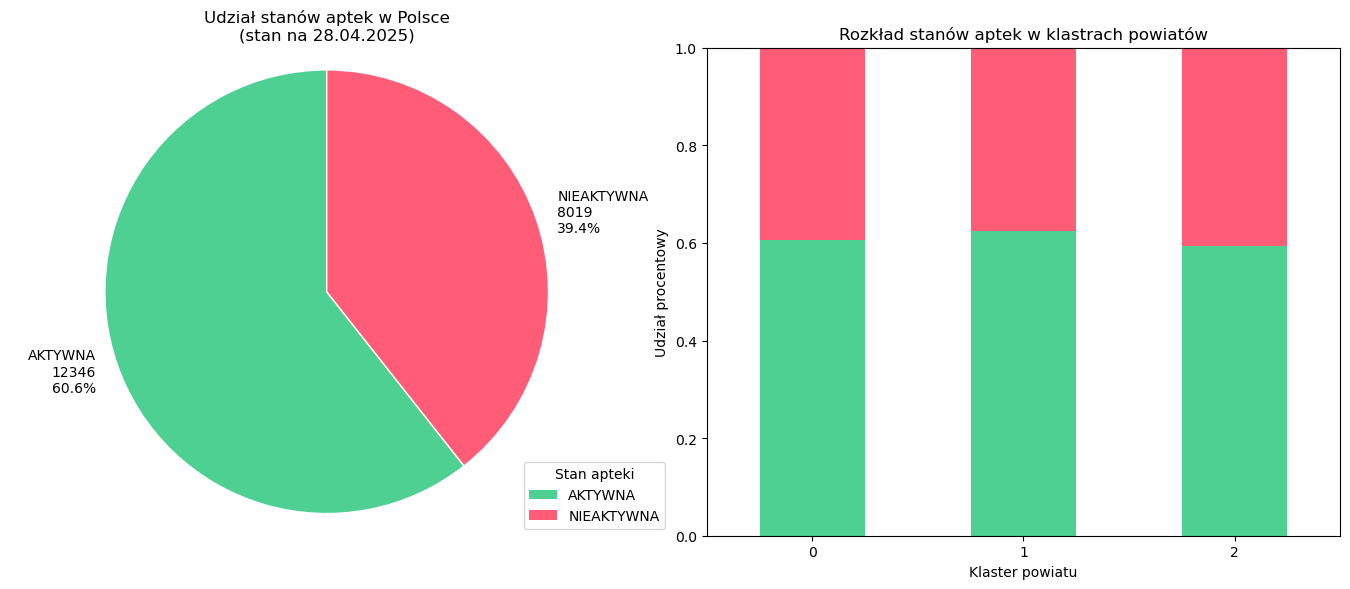

In [77]:
stan_counts = rejestr['stan_apteki'].value_counts()
labels = stan_counts.index
sizes = stan_counts.values
total = sizes.sum()
etykiety = [
    f"{label}\n{count}\n{count / total:.1%}"
    for label, count in zip(labels, sizes)
]
stan_klastry = rejestr.groupby(['klaster_powiat', 'stan_apteki']).size().unstack()
stan_klastry_pct = stan_klastry.div(stan_klastry.sum(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    sizes,
    labels=etykiety,
    startangle=90,
    colors=['#4dd091', '#ff5c77'],
    wedgeprops=dict(edgecolor='white')
)
axes[0].set_title("Udział stanów aptek w Polsce\n(stan na 28.04.2025)")
axes[0].axis('equal')

stan_klastry_pct.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    color=['#4dd091', '#ff5c77']
)
axes[1].set_title("Rozkład stanów aptek w klastrach powiatów")
axes[1].set_ylabel("Udział procentowy")
axes[1].set_xlabel("Klaster powiatu")
axes[1].set_ylim(0, 1)
axes[1].legend(title="Stan apteki", bbox_to_anchor=(-0.3, 0), loc='lower left')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

#### *rodzaj_apteki*
Kolejnym analizowanym aspektem charakterystyki aptek w Polsce jest ich rodzaj. Wykres kołowy przedstawia udział poszczególnych rodzajów aptek w Polsce. Zdecydowaną większość stanowią apteki ogólnodostępne, których jest 17902, co odpowiada 87,9% wszystkich placówek. Punkty apteczne to 2463 jednostki, czyli 12,1%. 

Wykres słupkowy ilustruje rozkład rodzajów aptek w trzech klastrach powiatów. W skali kraju apteki ogólnodostępne stanowią zdecydowaną większość wszystkich placówek aptecznych, natomiast punkty apteczne pełnią rolę uzupełniającą. Punkty apteczne są znacznie częściej spotykane w powiatach o niższej gęstości zaludnienia (klastry 0 i 1), co wskazuje na ich istotną rolę w zapewnianiu dostępu do leków na terenach słabiej zurbanizowanych. W największych miastach (klaster 2) dominują wyłącznie apteki ogólnodostępne. Może to świadczyć o wyższym poziomie infrastruktury farmaceutycznej w tych obszarach. Rozkład rodzajów aptek w poszczególnych klastrach odzwierciedla zróżnicowanie potrzeb lokalnych społeczności oraz dostosowanie sieci aptecznej do warunków demograficznych i urbanizacyjnych.

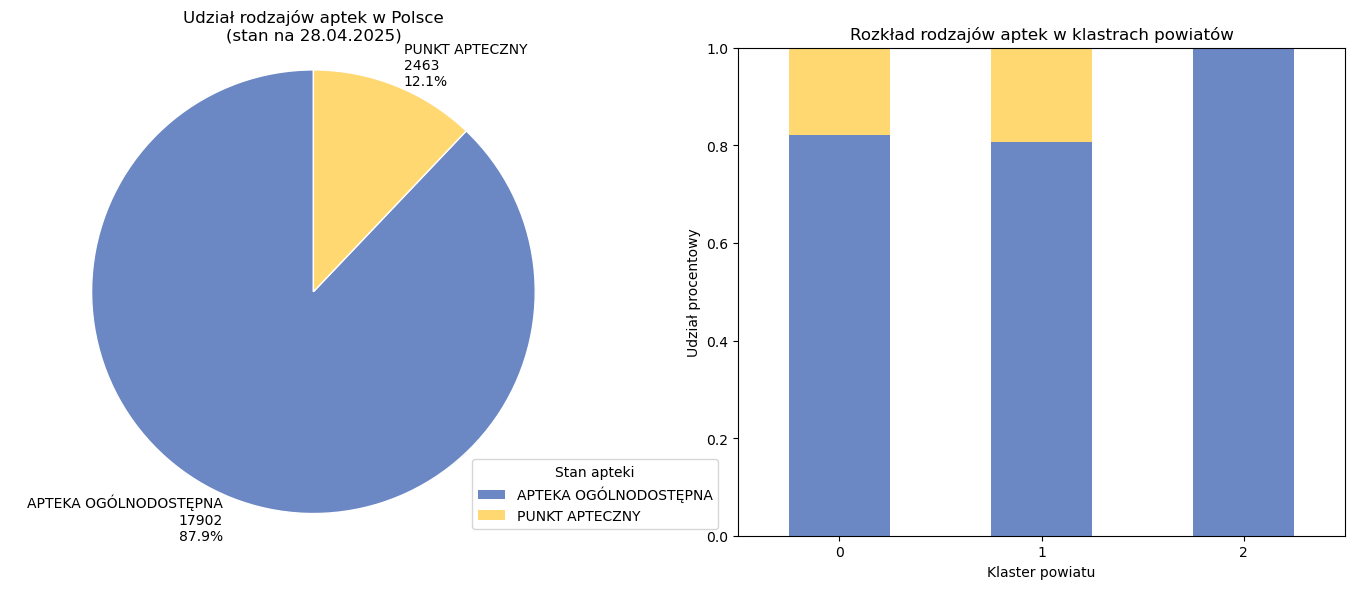

In [79]:
stan_counts = rejestr['rodzaj_apteki'].value_counts()
labels = stan_counts.index
sizes = stan_counts.values
total = sizes.sum()
etykiety = [
    f"{label}\n{count}\n{count / total:.1%}"
    for label, count in zip(labels, sizes)
]
stan_klastry = rejestr.groupby(['klaster_powiat', 'rodzaj_apteki']).size().unstack()
stan_klastry_pct = stan_klastry.div(stan_klastry.sum(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    sizes,
    labels=etykiety,
    startangle=90,
    colors=['#6c88c4', '#ffd872'],
    wedgeprops=dict(edgecolor='white')
)
axes[0].set_title("Udział rodzajów aptek w Polsce\n(stan na 28.04.2025)")
axes[0].axis('equal')

stan_klastry_pct.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    color=['#6c88c4', '#ffd872']
)
axes[1].set_title("Rozkład rodzajów aptek w klastrach powiatów")
axes[1].set_ylabel("Udział procentowy")
axes[1].set_xlabel("Klaster powiatu")
axes[1].set_ylim(0, 1)
axes[1].legend(title="Stan apteki", bbox_to_anchor=(-0.45, 0), loc='lower left')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

#### *wojewodztwo*

Następnie przeanalizowano rozmieszczenie aptek w układzie wojewódzkim. Wykres słupkowy przedstawia liczbę rekordów w rejestrze według województw. Najwięcej rekordów odnotowano w województwie mazowieckim, małopolskim, śląskim oraz wielkopolskim. Najmniej rekordów występuje w województwach opolskim, lubu-skim, podlaskim oraz świętokrzyskim. Pokrywa się to z najbardziej i najmniej zaludnionymi województwami. Największa liczba rekordów w rejestrze dotyczy województw z największymi miastami i aglomeracjami, co wskazuje na koncentrację infrastruktury medycznej oraz aptek w tych regionach.

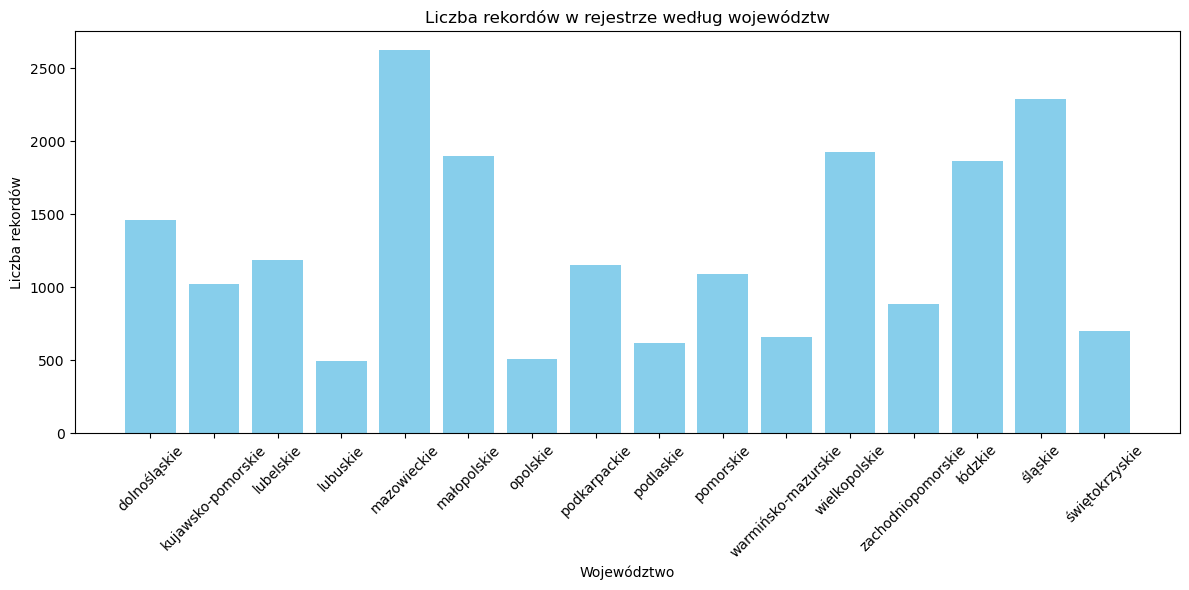

In [81]:
ilosc = rejestr['wojewodztwo'].value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(ilosc.index, ilosc.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('Liczba rekordów w rejestrze według województw')
plt.xlabel('Województwo')
plt.ylabel('Liczba rekordów')
plt.tight_layout()
plt.show()

#### *rok_uruchomienia_apteki & lata_dzialania*
Rozkład liczby aptek według roku ich uruchomienia stanowi kolejny element analizy. W danych widoczny jest pewien rozrzut w zakresie lat, bezpośrednio po roku 1900 pojawia się rok 1990, a kolejne lata są już reprezentowane w sposób ciągły. Sugeruje to, że apteki otwarte przed 1900 rokiem zostały przypisane właśnie do tej daty, co skutkuje wyraźnym pikiem w tym roku. Z kolei apteki otwarte w latach 1901–1989 przypisano do roku 1990, natomiast pozostałe uwzględniono zgodnie z rzeczywistą datą otwarcia. Zdecydowana większość aptek powstała po 1990 roku, przy czym szczególnie intensywny wzrost liczby nowych placówek obserwowano w latach 2000–2020. 

Drugi wykres ilustruje rozkład liczby aptek według długości ich działalności. Najwięcej placówek funkcjonuje od kilku do kilkudziesięciu lat, a największa koncentracja przypada na przedział od 5 do 20 lat działalności. Największy odsetek stanowią apteki stosunkowo młode, co wskazuje na dużą dynamikę w zakresie powstawania nowych punktów oraz możliwą rotację na rynku. Obserwuje się wyraźną przewagę aptek o krótkim i średnim stażu nad tymi, które działają od wielu dekad. Rozkład lat działalności potwierdza, że tylko nieliczne apteki mają ponad 100-letnią historię, co jest zbieżne z rozkładem roku ich uruchomienia.

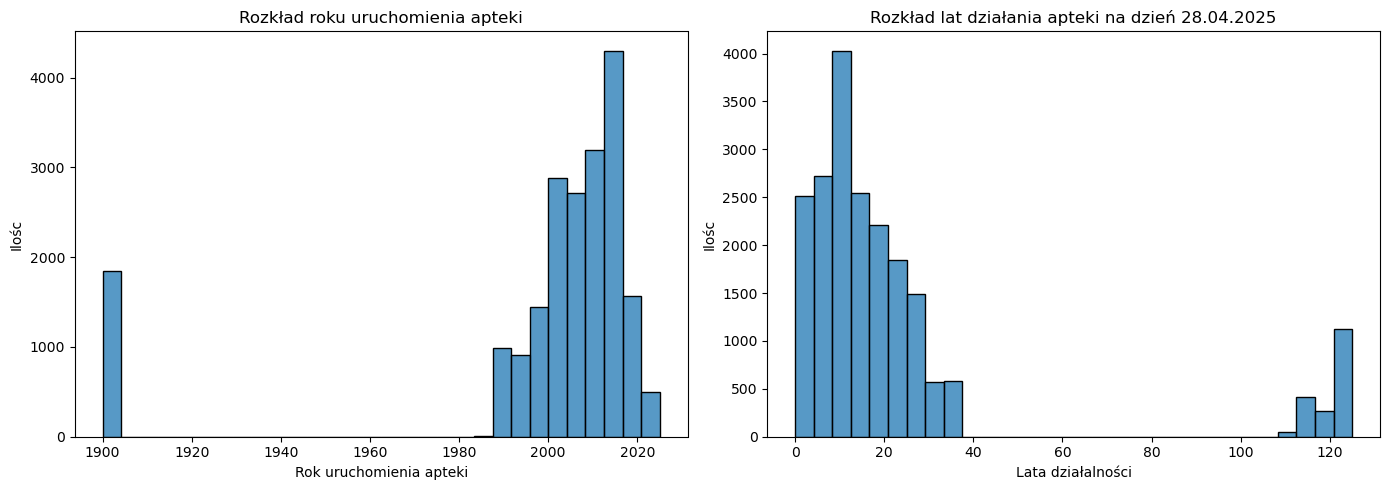

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(rejestr['rok_uruchomienia_apteki'], bins=30, ax=axs[0])
axs[0].set_title('Rozkład roku uruchomienia apteki')
axs[0].set_xlabel('Rok uruchomienia apteki')
axs[0].set_ylabel('Ilośc')

sns.histplot(rejestr['lata_dzialania'], bins=30, ax=axs[1])
axs[1].set_title('Rozkład lat działania apteki na dzień 28.04.2025')
axs[1].set_xlabel('Lata działalności')
axs[1].set_ylabel('Ilośc')

plt.tight_layout()
plt.show()

#### *czy_telefon & czy_email & czy_sprzedaz_wysylkowa*

Kolejnym elementem analizy były cechy takie jak dostępność numeru telefonu, adresu email oraz informacja o prowadzeniu sprzedaży wysyłkowej. We wszystkich trzech klastrach powiatów zdecydowana większość aptek posiada numer telefonu, odsetek ten przekracza 90%. Udział aptek bez telefonu jest znikomy i bardzo zbliżony we wszystkich klastrach, co pozwala uznać tę formę kontaktu za standard w skali kraju. Adres email deklaruje około 80–85% aptek, nieco mniej niż w przypadku telefonu. Również tutaj różnice między klastrami są niewielkie. 

Największe zróżnicowanie między klastrami obserwuje się w przypadku cechy sprzedaży wysyłkowej. Usługę tę oferuje jedynie niewielki odsetek aptek (poniżej 5%) we wszystkich klastrach. Jej udział jest jednak nieco wyższy w klastrze 2, obejmującym największe miasta i aglomeracje, co może wynikać z większego zapotrzebowania na tego typu usługi oraz lepszych warunków logistycznych w tych regionach.

In [85]:
x = rejestr.copy()
kod = {0: 'NIE', 1: 'TAK'}
x['czy_telefon'] = x['czy_telefon'].map(kod)
x['czy_email'] = x['czy_email'].map(kod)

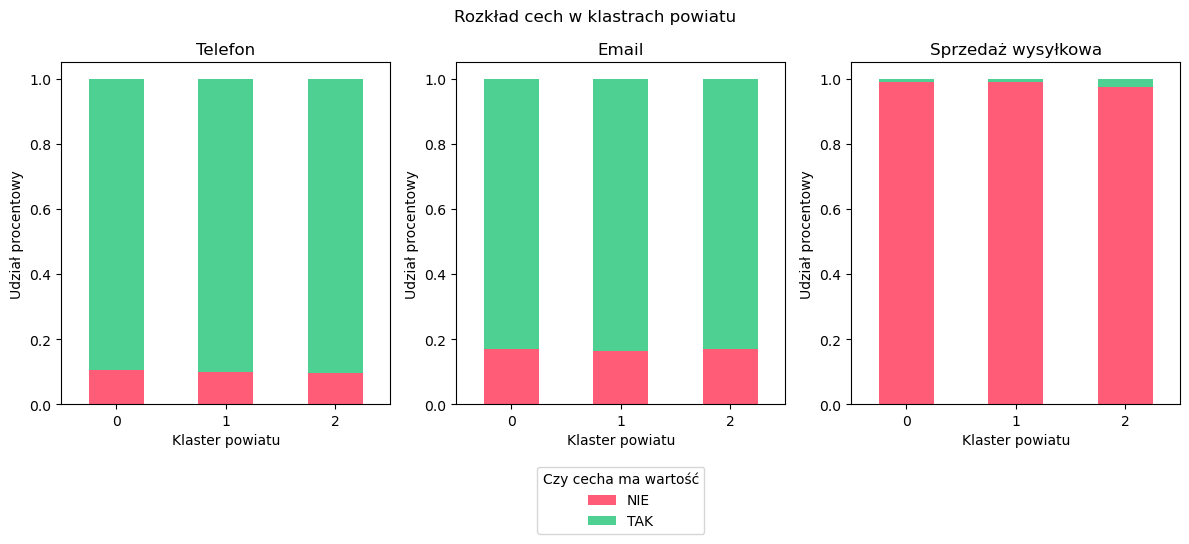

In [86]:
def rozklad(kolumna):
    tabela = x.groupby(['klaster_powiat', kolumna])[kolumna].count().unstack()
    tabela = tabela.div(tabela.sum(axis=1), axis=0)
    
    return tabela

telefon = rozklad('czy_telefon')
email = rozklad('czy_email')
sprzedaz = rozklad('czy_szprzedaz_wysylkowa')

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

telefon.plot(kind='bar', stacked=True, color=['#ff5c77', '#4dd091'], ax=axes[0])
axes[0].set_title("Telefon")
axes[0].set_ylabel("Udział procentowy")
axes[0].set_xlabel("Klaster powiatu")
axes[0].legend().remove()
axes[0].tick_params(axis='x', rotation=0)

email.plot(kind='bar', stacked=True, color=['#ff5c77', '#4dd091'], ax=axes[1])
axes[1].set_title("Email")
axes[1].set_ylabel("Udział procentowy")
axes[1].set_xlabel("Klaster powiatu")
axes[1].legend(title="Czy cecha ma wartość", bbox_to_anchor=(0.5, -0.4), loc='lower center')
axes[1].tick_params(axis='x', rotation=0)

sprzedaz.plot(kind='bar', stacked=True, color=['#ff5c77', '#4dd091'], ax=axes[2])
axes[2].set_title("Sprzedaż wysyłkowa")
axes[2].set_ylabel("Udział procentowy")
axes[2].set_xlabel("Klaster powiatu")
axes[2].legend().remove() 
axes[2].tick_params(axis='x', rotation=0)

plt.suptitle("Rozkład cech w klastrach powiatu")
plt.tight_layout()
plt.show()

#### *forma_prawna_kategoria*

Rozkład form prawnych prowadzenia aptek znacząco różni się w zależności od charakterystyki powiatów, co można zaobserwować na poniższych wykresach. Zestawienie w formie wykresu słupkowego oraz mapy ciepła uwzględnia kategorie form prawnych. W klastrach 0 i 1, obejmujących obszary o niskiej gęstości zaludnienia, dominują apteki prowadzone przez osoby fizyczne (ponad 40%), co może wynikać z przewagi lokalnych działalności w tych środowiskach. W klastrze 2, który repre-zentuje aglomeracje, zaobserwowano odmienną strukturę. Dominującą formą prawną są spółki kapitałowe, które stanowią aż 43% wszystkich aptek w tej grupie. Udział osób fizycznych spada w tym przypadku do 27%. Może to świadczyć o większej złożoności działalności aptecznej w środowiskach wielkomiejskich, gdzie skala operacyjna, konkurencja oraz wymagania logistyczne są większe. Udział kategorii „inne” we wszystkich klastrach jest znikomy, co potwierdza marginalne znaczenie niestandardowych form prawnych. Stały udział spółek osobowych we wszystkich klastrach sugeruje, że ta forma działalności znajduje zastosowanie w różnych warunkach, zarówno na terenach miejskich, jak i wiejskich.

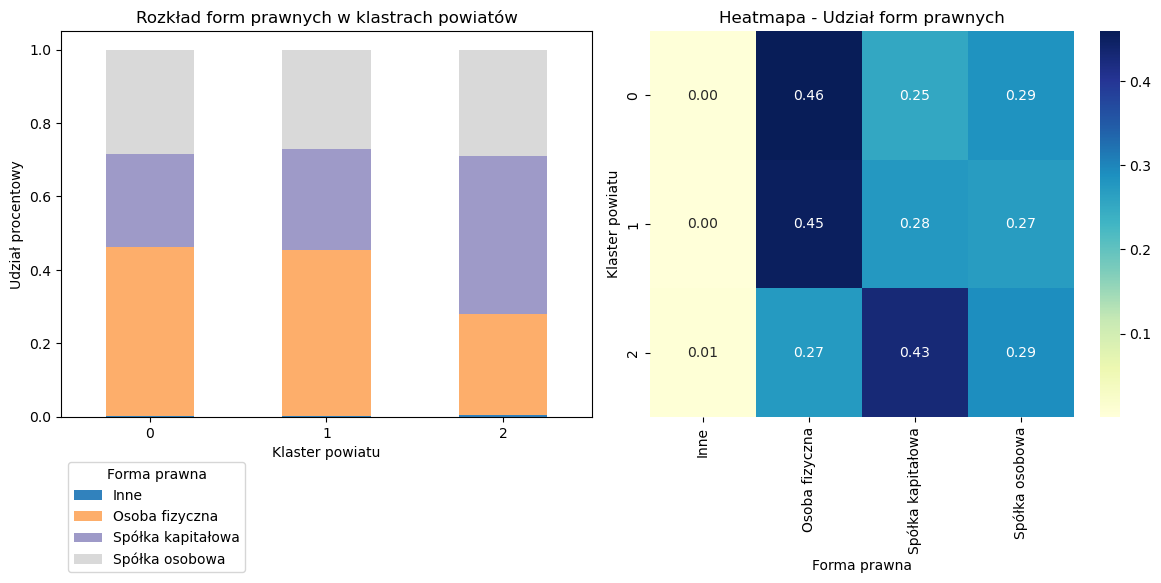

In [88]:
formy_klastry = rejestr.groupby(['klaster_powiat', 'forma_prawna_kategoria'])['forma_prawna_kategoria'].count().unstack()
formy_klastry_pct = formy_klastry.div(formy_klastry.sum(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

formy_klastry_pct.plot(kind='bar', stacked=True, colormap='tab20c', ax=axes[0])
axes[0].set_title("Rozkład form prawnych w klastrach powiatów")
axes[0].set_ylabel("Udział procentowy")
axes[0].set_xlabel("Klaster powiatu")
axes[0].legend(title="Forma prawna", bbox_to_anchor=(0, -0.1), loc='upper left')
axes[0].tick_params(axis='x', rotation=0)

sns.heatmap(formy_klastry_pct, annot=True, fmt=".2f", cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Heatmapa - Udział form prawnych")
axes[1].set_xlabel("Forma prawna")
axes[1].set_ylabel("Klaster powiatu")

plt.tight_layout()
plt.show()

#### *liczba aptek na przestrzeni lat*
Na poniższym wykresie zaprezentowano zmiany liczby aptek w Polsce w latach 1990–2024. Wcześniejsze dane nie zostały uwzględnione, ponieważ nie były aktualizowane corocznie, przez co wykres zaczyna się od pewnego poziomu liczby aptek. Dane ukazują wyraźny trend wzrostowy od początku lat 90. XX wieku aż do roku 2017, po którym nastąpił systematyczny spadek. W tych latach liczba aptek wzrosła ponad sześciokrotnie – z około 2,5 tysiąca do ponad 14,5 tysiąca. Tak dynamiczny przyrost można wiązać z brakiem ograniczeń regulacyjnych, które umożliwiły szerokiemu gronu przedsiębiorców zakładanie sieci aptecznych. 

Punkt zwrotny nastąpił po roku 2017, kiedy to wprowadzono nowelizację ustawy prawa farmaceutycznego, tzw. Apteka dla Aptekarza. Przepisy te ograniczyły możliwość zakładania nowych aptek wyłącznie do farmaceutów oraz wprowadziły kryteria geograficzne i demograficzne. Celem regulacji było ograniczenie ekspansji dużych sieci i wzmocnienie pozycji aptek indywidualnych. W efekcie, od 2017 roku obserwowany jest spadek liczby funkcjonujących aptek – do poziomu poniżej 12,5 tysiąca w roku 2024. Spadek liczby aptek może prowadzić do ograniczenia dostępności leków oraz pogorszenia warunków konkurencyjnych na rynku, szczególnie na obszarach wiejskich i w mniejszych miejscowościach. Zmiana ta wskazuje na konieczność dalszego monitorowania efektów wprowadzanych regulacji pod kątem ich wpływu na równomierne pokrycie terytorialne.

In [90]:
wojewodztwa = [
    "dolnośląskie", "kujawsko-pomorskie", "lubelskie", "lubuskie", "łódzkie",
    "małopolskie", "mazowieckie", "opolskie", "podkarpackie", "podlaskie",
    "pomorskie", "śląskie", "świętokrzyskie", "warmińsko-mazurskie",
    "wielkopolskie", "zachodniopomorskie"
]

x = {}

for woj in wojewodztwa:
    d = r[r['wojewodztwo'] == woj]
    g1 = d.groupby('rok_uruchomienia_apteki').size().rename('ilość nowych aptek')
    g2 = d.groupby('rok_konca_zezwolenia').size().rename('ilość zamkniętych aptek')
    daty = pd.concat([g1, g2], axis=1).fillna(0).astype(int)  
    
    x[woj] = daty
    rozklad = pd.concat(x, axis=1)

rozklad = rozklad.sort_index().fillna(0)
rozklad.loc[1990] = rozklad.loc[1901:1990].sum()
rozklad.drop(rozklad.loc[1901:1989].index, inplace=True)

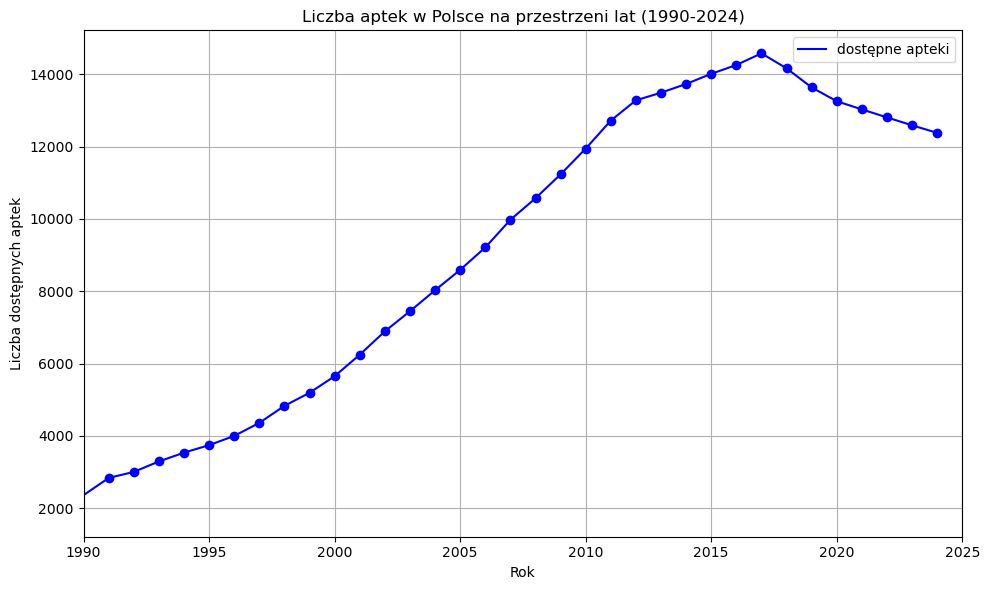

In [91]:
nowe = rozklad.xs('ilość nowych aptek', axis=1, level=1).sum(axis=1)
zamkniete = rozklad.xs('ilość zamkniętych aptek', axis=1, level=1).sum(axis=1)
bilans = nowe - zamkniete

liczba_aptek_start = nowe.loc[1900]
bilans_po_1900 = bilans.loc[1901:]

dostepne_apteki = bilans_po_1900.cumsum() + liczba_aptek_start
dostepne_apteki.loc[1900] = liczba_aptek_start
dostepne_apteki = dostepne_apteki.sort_index()

trend = pd.DataFrame({
    'dostępne apteki': dostepne_apteki
})

trend = trend.loc[:2024]
trend.plot(kind='line', figsize=(10, 6), title='Liczba aptek w Polsce na przestrzeni lat (1990-2024)', color='blue')
plt.xlabel('Rok')
plt.ylabel('Liczba dostępnych aptek')
plt.xlim(1990, 2025)
plt.grid(True)

maska = trend.index != 1990
plt.scatter(trend.index[maska], trend['dostępne apteki'][maska], color='blue', zorder=4, label='nowe apteki')

plt.tight_layout()
plt.show()

#### *trend zmian liczby aptek*

Trend zmian liczby aptek w latach 1990–2024 przedstawiono na poniższym wykresie. Potwierdza się na nim, że od 2017 roku nastąpił gwałtowny spadek liczby nowo otwieranych aptek. Już w 2018 roku bilans nowo powstałych placówek stał się ujemny i utrzymuje się na ujemnym poziomie do dziś. Jednocześnie wykres wskazuje na inną istotną tendencję, od 2011 roku obserwowany jest wyraźny wzrost liczby zamykanych aptek, podczas gdy wcześniej ich liczba była niska. W 2011 roku wprowadzono ustawę refundacyjną, która ustanowiła sztywne ceny i marże na leki refundowane oraz ograniczyła możliwość stosowania promocji i rabatów przez apteki. W efekcie sytuacja finansowa wielu małych, indywidualnych aptek uległa znacznemu pogorszeniu, co przyczyniło się do ich upadku oraz przyspieszyło ekspansję dużych sieci aptecznych.

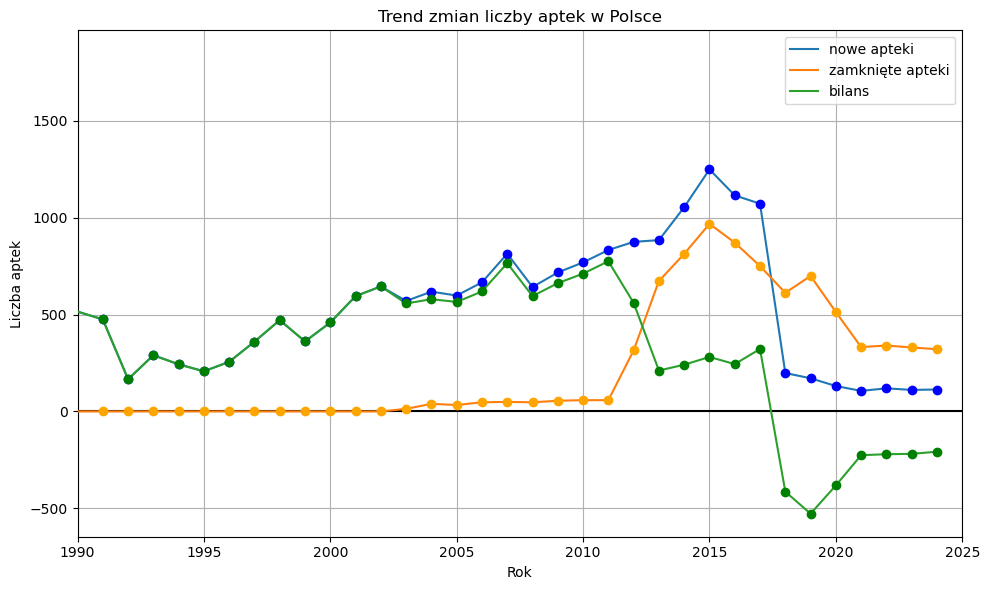

In [93]:
trend = pd.DataFrame({
    'nowe apteki': nowe,
    'zamknięte apteki': zamkniete,
    'bilans': bilans
})

trend = trend.loc[:2024]

trend.plot(kind='line', figsize=(10, 6), title='Trend zmian liczby aptek w Polsce', zorder=3)
plt.axhline(y=0, color='black', linewidth=1.5, linestyle='-', zorder=2)
plt.xlim(1990, 2025)
plt.xlabel('Rok')
plt.ylabel('Liczba aptek')
plt.grid(True)

maska = trend.index != 1990

plt.scatter(trend.index[maska], trend['nowe apteki'][maska], color='blue', zorder=4, label='nowe apteki')
plt.scatter(trend.index[maska], trend['zamknięte apteki'][maska], color='orange', zorder=4, label='zamknięte apteki')
plt.scatter(trend.index[maska], trend['bilans'][maska], color='green', zorder=4, label='bilans')

plt.tight_layout()
plt.show()

### Kodowanie zmiennych kategorycznych
Kolejnym krokiem było przygotowanie zmiennych kategorycznych do wykorzystania w modelach uczenia maszynowego, które wymagają danych w formacie numerycznym. W tym celu zastosowano kodowanie numeryczne wybranych cech, tak aby w zbiorze danych nie pozostały już żadne nienumeryczne kolumny. Zmienne tekstowe zostały zmapowane na wartości całkowite przy użyciu predefiniowanych słowników.

In [95]:
kod1 = {"NIEAKTYWNA" : 0, "AKTYWNA" : 1}
kod2 = {"APTEKA OGÓLNODOSTĘPNA" : 0, "PUNKT APTECZNY" : 1}
kod3 = {
    "dolnośląskie": 2,
    "kujawsko-pomorskie": 4,
    "lubelskie": 6,
    "lubuskie": 8,
    "łódzkie": 10,
    "małopolskie": 12,
    "mazowieckie": 14,
    "opolskie": 16,
    "podkarpackie": 18,
    "podlaskie": 20,
    "pomorskie": 22,
    "śląskie": 24,
    "świętokrzyskie": 26,
    "warmińsko-mazurskie": 28,
    "wielkopolskie": 30,
    "zachodniopomorskie": 32
}
kod4 = {"NIE" : 0, "TAK" : 1}
kod5 = {"Inne" : 0, "Spółka osobowa" : 1, "Spółka kapitałowa" : 2, "Osoba fizyczna" : 3}
rejestr["stan_apteki"] = rejestr["stan_apteki"].map(kod1)
rejestr["rodzaj_apteki"] = rejestr["rodzaj_apteki"].map(kod2)
rejestr["wojewodztwo"] = rejestr["wojewodztwo"].map(kod3)
rejestr["czy_szprzedaz_wysylkowa"] = rejestr["czy_szprzedaz_wysylkowa"].map(kod4)
rejestr["forma_prawna_kategoria"] = rejestr["forma_prawna_kategoria"].map(kod5)

In [96]:
rejestr.dtypes.to_frame(name='Typ zmiennej').rename_axis('Cecha')

,Typ zmiennej
Cecha,
stan_apteki,int64
rodzaj_apteki,int64
wojewodztwo,int64
klaster_powiat,int64
rok_uruchomienia_apteki,int32
lata_dzialania,int64
czy_szprzedaz_wysylkowa,int64
czy_telefon,int64
czy_email,int64


### Wybór zmiennej *target* do uczenia nadzorowanego 

Do uczenia nadzorowanego jako zmienną target wybrano kolumnę lata_dzialania. Zmienna ta jest dobrym kandydatem, szczególnie w kontekście analizy regresyjnej. Celem takiego modelu mogłoby być przewidywanie, jak długo dana apteka będzie funkcjonować na rynku. Informacja ta ma wartość biznesową, ponieważ pozwala na identyfikację czynników wpływających na stabilność i długowieczność aptek. Co więcej, dane dotyczące lat działalności zostały wcześniej przygotowane i przetworzone, m.in. poprzez redukcję kardynalności do poziomu roku, co ułatwia ich modelowanie. W przypadku aptek wciąż aktywnych, okres ten jest liczony do roku 2025, co odzwierciedla ich aktualny staż funkcjonowania.

### Wybór zmiennych *features*

Do wyznaczenia zmiennej target (lata_dzialania) można wybrać następujący podzbiór zmiennych features:
- ***rodzaj_apteki***: Rodzaj apteki może wpływać na jej stabilność i długość działania. W raporcie zauważono, że punkty apteczne pełnią rolę uzupełniającą, szczególnie na terenach słabiej zurbanizowanych, co może wiązać się z innymi uwarunkowaniami rynkowymi niż w przypadku aptek ogólnodostępnych.

- ***klaster_powiat***: Zmienna ta powstała w wyniku klasteryzacji powiatów pod względem gęstości zaludnienia i obciążenia aptek. Charakterystyka klastra, w którym działa apteka, może mieć istotny wpływ na jej perspektywy i czas funkcjonowania.
- ***wojewodztwo***: Lokalizacja na poziomie województwa może odzwierciedlać regionalne uwarunkowania ekonomiczne, demograficzne oraz specyfikę rynku farmaceutycznego, co może wpływać na długość działania apteki.
- ***czy_szprzedaz_wysylkowa***: Prowadzenie sprzedaży wysyłkowej może być czynnikiem różnicującym, wpływającym na zasięg i potencjalne przychody apteki, a tym samym na jej żywotność.
- ***czy_telefon*** oraz ***czy_email***: Posiadanie danych kontaktowych, takich jak telefon czy email, może świadczyć o pewnym poziomie organizacji i profesjonalizmu apteki, co pośrednio może przekładać się na jej stabilność.
- ***forma_prawna_kategoria***: Kategoria formy prawnej właściciela apteki może mieć związek z jej stabilnością finansową, dostępem do kapitału i strategią działania. Analiza wykazała różnice w dominujących kategoriach form prawnych w zależności od klastra powiatu, co sugeruje ich potencjalny wpływ na funkcjonowanie aptek.
- ***rok_uruchomienia_apteki***: Chociaż lata_dzialania są bezpośrednio powiązane z rokiem uruchomienia, sama data startu może nieść dodatkowe informacje o warunkach rynkowych panujących w momencie otwarcia apteki (np. zmiany regulacyjne, nasycenie rynku), które mogły wpłynąć na jej dalsze losy.